In [1]:
import torch
import numpy as np
import argparse
import pickle
import matplotlib.pyplot as plt
from matplotlib.image import imread
import matplotlib.gridspec as gridspec
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import random
from tqdm import tqdm

import os
print(os.getcwd())


from datetime import datetime

from neural_concept_binder import NeuralConceptBinder
from neural_concept_binder import SysBinderImageAutoEncoder
import utils_ncb as utils


THRESH_OBJ_IN_SLOT = 0.98 # found heuristically/visually

seed = 0
torch.manual_seed(seed)
device = 'cuda'

parser = utils.get_parser(device)

args = parser.parse_args(args = [])
args.num_blocks = 16
args.batch_size = 20
args.clf_type = "dt"
args.thresh_count_obj_slots = 0

base_log_path = f"/app/ncb/CLEVR-4/retbind_seed_{seed}/"
args.checkpoint_path = base_log_path + 'best_model.pt'
args.retrieval_corpus_path = base_log_path + 'block_concept_dicts.pkl'
args.thresh_count_obj_slots = 0

# model = SysBinderImageAutoEncoder(args)
model = NeuralConceptBinder(args)           # automatically loads the model internally
                                        # if I want to have "normal" model encodings, I should use the SysBinder...
# checkpoint_path = "../logs/sysbind_orig_seed0/checkpoint.pt.tar"

# checkpoint = torch.load(checkpoint_path, map_location="cpu")
# model.load_state_dict(checkpoint['model'])

model.to(device)

model.eval()
model.model.eval()

/app/sam2
Loading retrieval corpus from /app/ncb/CLEVR-4/retbind_seed_0/block_concept_dicts.pkl ...

Number of concepts per block: 
[3, 8, 12, 264, 7, 15, 1, 2, 5, 1, 11, 1, 20, 5, 1, 3]



/usr/local/lib/python3.12/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/app/ncb/neural_concept_binder.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_

loaded .../app/ncb/CLEVR-4/retbind_seed_0/best_model.pt


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacity of 23.65 GiB of which 2.50 MiB is free. Process 211835 has 22.93 GiB memory in use. Process 213954 has 720.00 MiB memory in use. Of the allocated memory 316.97 MiB is allocated by PyTorch, and 17.03 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [3]:
dict_path = args.retrieval_corpus_path
with open (dict_path, "rb") as f:
    block_concepts = pickle.load(f) 

# length 8
# each: prototypes, exemplars, params_clustering, sivm_basis
    # prototypes: prototypes (256, 0) * N_clusters, ids (N_clusters, 1)
    # exemplars: exemplar_ids list(N_Clusters), ids (N_exemplars,), exemplars (N_exemplars, 256)
    #   exemplar ids are the image ids from which the exemplars stem

with open(base_log_path + "all_img_locs.pkl", "rb") as f:
    all_img_locs = pickle.load(f)

# list of len(N), each entry contains a path to the image (ordered as done in training)
# path originates from project root

In [3]:
def change_img_locs():
    for i in range(len(all_img_locs)):
        if "wolf" in all_img_locs[i]:
            all_img_locs[i] = "data/" + "/".join(all_img_locs[i].split("/")[3:])

change_img_locs()


In [4]:
def transform_np_slots_to_torch_slots(np_slots):
    slots = torch.tensor(np_slots).to(device)
    return slots.unsqueeze(0)

def random_prototype(block_id: int, cluster_id: int, num_generations: int):
    """
    Generate a full slot for prototypes of the given block and cluster (with random exemplars for the other blocks).
    """
    if cluster_id >= len(block_concepts[block_id]['prototypes']['ids']):
        raise ValueError("Specified cluster id exceeds number of clusters.")
    proto_enc = block_concepts[block_id]['prototypes']['prototypes'][cluster_id]
    
    generated = []
    for _ in range(num_generations):
        result_enc = []
        for block in range(8):
            if block == block_id:  # we already have an encoding for the prototype block
                result_enc.append(proto_enc)
            else:
                # use the encodings of a random exemplar
                num_exemplars = len(block_concepts[block]['exemplars']['ids'])
                n = np.random.randint(num_exemplars)
                result_enc.append(block_concepts[block]['exemplars']['exemplars'][n])

        generated.append(np.concatenate(result_enc))

    return np.stack(generated)

def tensor_img_to_np(img: torch.tensor):
    img = img.detach().cpu().numpy()
    if len(img.shape) == 4:
        img = np.swapaxes(img, 1, 2)
        img = np.swapaxes(img, 2, 3)
    else:
        img = np.swapaxes(img, 0, 1)
        img = np.swapaxes(img, 1, 2)
    return img

def load_img_as_tensor(file_path: str|list[str]):
    if type(file_path) == str:
        img = imread(file_path)[:,:,:3]  # discard the alpha values
        img = torch.tensor(img, device=device).unsqueeze(0)  # add an extra dimension for the number of images
        # reorder dimensions for network
        img = torch.swapaxes(img, 2, 3)
        img = torch.swapaxes(img, 1, 2)
        res = img
    else:
        res = []
        for f in file_path:
            img = imread(f)[:,:,:3]  # discard the alpha values
            img = torch.tensor(img, device=device).unsqueeze(0)  # add an extra dimension for the number of images
            # reorder dimensions for network
            img = torch.swapaxes(img, 2, 3)
            img = torch.swapaxes(img, 1, 2)
            res.append(img)
        
        res = torch.concatenate(res)
        print(res.size())

    return res

def slot_by_image(encoding: torch.tensor):
    """
    Return the slot in which the object is located.
    To evaluate this, encode all slots and use the one with the minimum distance to the original image
    """
    slot_sums = np.zeros(4)
    
    for s in range(4):
        slot = encoding[:, s, :].unsqueeze(0)
        img = model.model.decode(slot)
        img = tensor_img_to_np(img)[0]
        slot_sums[s] += np.sum(img)
        
    img = model.model.decode(encoding)
    img = tensor_img_to_np(img)[0]

    full_sum = np.sum(img)

    slot_sums -= full_sum
    img_slot = np.argmin(np.abs(slot_sums))
    
    return img_slot

def slot_based_on_encoding(encoding: torch.tensor):
    """
    Infer the slot in which the object is based on the retrieved encodings.
    """
    encoding = encoding[0]
    res = np.zeros(encoding.shape[0])
    for i in range(encoding.shape[0]):
        s = [torch.abs(encoding[i, :] - encoding[j, :]).sum().item() for j in range(encoding.shape[0])]
        res[i] = sum(s)
    
    return np.argmax(res)

def swap_block(source: torch.tensor, target: torch.tensor, block_id: int, slot_id: int):
    """
    overwrites the slot_id[block_id] block from the target with the source encoding.
    if both source and target are full encodings, swap the blocks of both.
    """
    t = target.clone()
    s = source.clone()
    if len(source.size()) == 1:
        # source is only a block encoding
        t[:, slot_id, block_id * 256:(block_id + 1)*256] = s
    else:
        # both are full encodings - swap blocks
        tmp = t[:, slot_id, block_id * 256:(block_id + 1)*256].clone()
        t[:, slot_id, block_id * 256:(block_id + 1)*256] = s[:, slot_id, block_id * 256:(block_id + 1)*256].clone()
        s[:, slot_id, block_id * 256:(block_id + 1)*256] = tmp

    return s, t

def select_exemplar(block_id: int, cluster_id: int, exemplar_id: int = -1):
    """
    Select an exemplar from the specified cluster.
    If exemplar_id is -1, a random exemplar is selected.
    """
    exemplars = block_concepts[block_id]['exemplars']['exemplars']
    ids = block_concepts[block_id]['exemplars']['ids']
    cluster_sizes = [len([i for i in ids if i == c]) for c in np.unique(ids)]
    start_id = sum(cluster_sizes[:cluster_id])

    if exemplar_id != -1:
        # custom exemplar id selected
        assert exemplar_id < cluster_sizes[cluster_id], "Exemplar id exceeds number of exemplars in this cluster."
        return exemplars[start_id + exemplar_id]
    else:
        # random exemplar selected
        n = np.random.randint(cluster_sizes[cluster_id])
        return exemplars[start_id + n]

In [5]:
def vis_clusters_by_random_generations():
    """
    generate and visualize prototypes for all blocks (only 1 slot, random exemplars for the other blocks)
    """

    # get the images of random generated protoype visualization (1 slot)
    proto_generation = []
    for b in range(8):
        block_generation = []
        for i in range(min(len(block_concepts[b]['prototypes']['ids']) - 1, 10)):
            print(f"Block: {b}, cluster: {i}")
            tmp = random_prototype(b, i, 16)

            tmp = transform_np_slots_to_torch_slots(tmp)
            tmp = torch.swapaxes(tmp, 0, 1)

            tmp.to(device)
        
            tmp = model.model.decode(tmp)
            tmp = tensor_img_to_np(tmp)

            block_generation.append(tmp)
        proto_generation.append(block_generation)

    # plot these images
    for b, block_gen in enumerate(proto_generation):
        
        for c, cluster_gen in enumerate(block_gen):
            fig, axs = plt.subplots(2, 8)
            axs = axs.flatten()
            
            for i in range(len(axs)):
                axs[i].imshow(cluster_gen[i])
                axs[i].axis('off')
            fig.suptitle(f'Block: {b}, Cluster: {c}')
            fig.tight_layout()

    plt.show()

def vis_clusters_by_swapping(use_prototypes: bool = True, img_ids: list[int] = None):
    """
    Visualize each cluster of all blocks by swapping the encoding of selected images with the encoding of prototypes/exemplars of the respective cluster.
    """
    if img_ids is None:
        img_ids = range(10)

    img_paths = ["../" + all_img_locs[i] for i in img_ids]
    encodings = [model.model.encode(img)[0] for img in img_paths]
    img_slots = [slot_by_image(encoding) for encoding in encodings]


    fig = plt.figure(figsize=(10, 90))
    n_clusters = [min(len(block_concepts[b]['prototypes']['ids']) - 1, 10) for b in range(8)]
    block_grid = gridspec.GridSpec(8, 1, height_ratios=n_clusters)

    for b in range(8):
        cluster_grid = gridspec.GridSpecFromSubplotSpec(n_clusters[b], 1, subplot_spec=block_grid[b], wspace=0.0, hspace=0.3)
        for c in range(n_clusters[b]):
            # for all 10 images:
            # swap the respective block with the prototype, plot before and after.
            # plot layout: 2 x 10 (top is before, bottom is after swap)

            inner_grid = gridspec.GridSpecFromSubplotSpec(2, 10, subplot_spec=cluster_grid[c], wspace=0.0, hspace=0.1)
            if use_prototypes:
                swap_enc = torch.tensor(block_concepts[b]['prototypes']['prototypes'][c], device=device)
            else:
                swap_enc = torch.tensor(select_exemplar(b, c, 1), device=device)
            for i in range(10):
                orig_ax = fig.add_subplot(inner_grid[0, i])
                swap_ax = fig.add_subplot(inner_grid[1, i])
                # orig_img
                orig_ax.imshow(imread(img_paths[i]))
                # swapped img:
                _, t = swap_block(swap_enc, encodings[i], b, img_slots[i])
                swapped_img = tensor_img_to_np(model.model.decode(t))[0]
                swap_ax.imshow(swapped_img)
                # swap_ax.imshow(imread(paths[i]))
                if i == 0 and c == 0:
                    orig_ax.set_title(f"Block {b}, Cluster {c}")
                elif i == 0 and c != 0:
                    orig_ax.set_title(f"Cluster {c}")

                if i == 0:
                    orig_ax.set_ylabel("Original")
                    swap_ax.set_ylabel("Swapped")
                    orig_ax.tick_params(left = False, bottom=False, labelleft=False, labelbottom=False)
                    swap_ax.tick_params(left = False, bottom=False, labelleft=False, labelbottom=False)
                else:
                    orig_ax.axis('off')
                    swap_ax.axis('off')
            # somehow set the title of the block plots
    plt.show()

Block:  0
/app/clevr_images/train/images/CLEVR_4_classid_0_000259.png
/app/clevr_images/train/images/CLEVR_4_classid_0_002553.png
/app/clevr_images/train/images/CLEVR_4_classid_0_002261.png
/app/clevr_images/train/images/CLEVR_4_classid_0_001999.png
/app/clevr_images/train/images/CLEVR_4_classid_0_004363.png


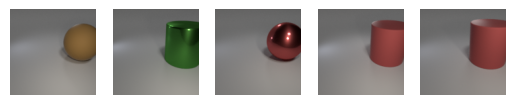

/app/clevr_images/train/images/CLEVR_4_classid_0_000456.png
/app/clevr_images/train/images/CLEVR_4_classid_0_002948.png
/app/clevr_images/train/images/CLEVR_4_classid_0_003471.png
/app/clevr_images/train/images/CLEVR_4_classid_0_000307.png
/app/clevr_images/train/images/CLEVR_4_classid_0_000615.png


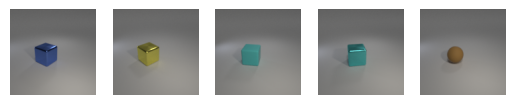

/app/clevr_images/train/images/CLEVR_4_classid_0_001032.png
/app/clevr_images/train/images/CLEVR_4_classid_0_001160.png
/app/clevr_images/train/images/CLEVR_4_classid_0_003685.png
/app/clevr_images/train/images/CLEVR_4_classid_0_002554.png
/app/clevr_images/train/images/CLEVR_4_classid_0_000370.png


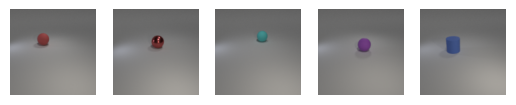

In [5]:
### part 1: implicit inspection:
# "What are examples of the concept?"

def implicit_inspection(block_id: int, cluster_id: int, exp_per_cluster: int = 5, title: str = None):
    """
    Direct inspection of the exemplars of a cluster.
    Generates a plot with exp_per_cluster exemplars of the specified cluster from the specified block.
    """
    assert cluster_id <= len(block_concepts[block_id]['prototypes']['ids']), "Cluster id exceeds number of clusters."
    if len(block_concepts[block_id]['exemplars']['exemplar_ids'][cluster_id]) < exp_per_cluster:
        print("Not enough exemplars in the cluster to generate the specified number of examples.")
        return

    fig, axs = plt.subplots(1, exp_per_cluster)

    base_path = "/app/clevr_images/train/images/"

    for i in range(exp_per_cluster):
        id = block_concepts[block_id]['exemplars']['exemplar_ids'][cluster_id][i]
        path = all_img_locs[id]

        print(os.path.join(base_path, os.path.basename(path)))

        axs[i].imshow(imread(os.path.join(base_path, os.path.basename(path))))
        axs[i].axis('off')

    if title is None:
        plt.show()
        plt.close()
    # else:
    #     plt.savefig(f"plots/{title}.pdf")

for b in range(0, 1):
    n_clusters = len(block_concepts[b]['prototypes']['ids'])
    print("Block: ", b)
    for c in range(n_clusters):
        implicit_inspection(b, c)

# implicit_inspection(1, 0, 5, "implicit_inspection_b1_c0")
# implicit_inspection(7, 1, 5, "implicit_inspection_b7_c1")
# implicit_inspection(3, 0, 5, "implicit_inspection_b3_c0")

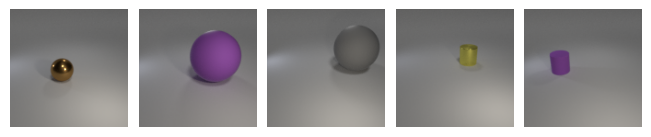

In [54]:
### Part 2: Comparative Inspection
# What are examples of a different, yet similar concept?
# Why is it this concept and not the other?
# given: 1 image, 1 present concept (block_id) and 1 different concept from that block (cluster_id)
# present 5 2/3 exemplars from the same concept and the same number from the different concept

def comparative_inspection(example_path: str, block_id: int, cluster_id: int, num_exemplars: int = 2, title: str = "comparative_inspection"):
    """
    Given an image, show examples of the same and a different concept from the specified block.
    """
    assert cluster_id <= len(block_concepts[block_id]['prototypes']['ids']), "Cluster id exceeds number of clusters."

    fig = plt.figure(constrained_layout=True)

    subfigs = fig.subfigures(1, (num_exemplars*2+1))

    path_prefix = "/app/clevr_images/train/images/"
    img_path = os.path.join(path_prefix, os.path.basename(example_path))
    enc = model.encode(load_img_as_tensor(img_path))
    slot = slot_based_on_encoding(enc[0])

    for outerind, subfig in enumerate(subfigs.flat):
        if outerind == 0:
            axs = subfig.subplots(1, 1)
            img_path = os.path.join(path_prefix, os.path.basename(example_path))
            axs.imshow(imread(img_path))
            axs.axis('off')

        elif outerind >= 1 and outerind <= num_exemplars:
            this_cluster = int(enc[0][0, slot, block_id].item())

            axs = subfig.subplots(1, 1)
            id = block_concepts[block_id]['exemplars']['exemplar_ids'][this_cluster][outerind + 1]
            path = all_img_locs[id]
            img_path = os.path.join(path_prefix, os.path.basename(path))
            axs.imshow(imread(img_path))
            axs.axis('off')

        
        elif outerind > num_exemplars:
            axs = subfig.subplots(1, 1)
            id = block_concepts[block_id]['exemplars']['exemplar_ids'][cluster_id][outerind]
            path = all_img_locs[id]
            img_path = os.path.join(path_prefix, os.path.basename(path))
            axs.imshow(imread(img_path))
            axs.axis('off')
        
        # subfig.suptitle(f'Subfig {outerind}')
        # axs = subfig.subplots(2, 1)
        # for innerind, ax in enumerate(axs.flat):
        #     ax.set_title(f'outer={outerind}, inner={innerind}', fontsize='small')
        #     ax.set_xticks([])
        #     ax.set_yticks([])
    
    # plt.savefig(f"plots/{title}.pdf")
    
p = all_img_locs[0]
# comparative_inspection(p, 7, 1, 2, title="comparative_inspection_2")
# comparative_inspection(p, 7, 0, 2, title="comparative_inspection_1")
# comparative_inspection(p, 1, 0, 2, title="comparative_inspection_3")
comparative_inspection(p, 1, 1, 2, title="comparative_inspection_4")

# image 0, block 7, cluster 4 compared to 5 and 0
# image 0, block 1, cluster 2 compared to 1 and 0

In [43]:
### part 3: Altering/Conceptual Inspection
# What if this object had this concept? E.g. red instaed of blue?
# given: 1 image, 1 present concept (block_id) and 1 different concept from that block (cluster_id)
# Use the prototype of the different concept and swap the block encoding with the given image.

def conceptual_inspection(example_path: str, block_id: int, cluster_id: int, title: str = None):
    """
    Given an image, show examples of the same and a different concept from the specified block.
    """
    assert cluster_id <= len(block_concepts[block_id]['prototypes']['ids']), "Cluster id exceeds number of clusters."

    path_prefix = "/app/clevr_images/train/images/"
    img_path = os.path.join(path_prefix, os.path.basename(example_path))

    img = load_img_as_tensor(img_path)
    # ret_enc = model.encode(img)
    # slot = slot_based_on_encoding(ret_enc[0])
    enc = model.model.encode(img)
    proto_enc = torch.tensor(block_concepts[block_id]['prototypes']['prototypes'][cluster_id], device=device)

    slot_id = 0
    new_enc = swap_block(proto_enc, enc[0], block_id, slot_id)[1]

    img = tensor_img_to_np(model.model.decode(new_enc))[0]

    fig = plt.figure(figsize=(2, 2))
    plt.imshow(img)
    plt.axis('off')

    if title is None:
        plt.show()
        plt.close()
    # else:
    #     plt.savefig(f"plots/{title}.pdf")


# image 0, block 7, cluster 4 compared to 1 and 0
# image 0, block 1, cluster 2 compared to 1 and 0

p = all_img_locs[0]
conceptual_inspection(p, 7, 0, title="conceptual_inspection7_0")
conceptual_inspection(p, 7, 1, title="conceptual_inspection7_1")
conceptual_inspection(p, 1, 0, title="conceptual_inspection1_0")
conceptual_inspection(p, 1, 1, title="conceptual_inspection1_1")

RuntimeError: The expanded size of the tensor (256) must match the existing size (128) at non-singleton dimension 1.  Target sizes: [1, 256].  Tensor sizes: [128]

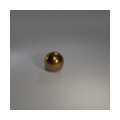

RuntimeError: selected index k out of range

In [42]:
def image_similatities(img_id: int, block_id: int):
    path_prefix = "/app/clevr_images/train/images/"
    img_path = os.path.join(path_prefix, os.path.basename(all_img_locs[img_id]))
    
    img = load_img_as_tensor(img_path)
    fig = plt.figure(figsize=(1, 1))
    ax = plt.axes([0, 0, 1, 1])
    ax.axis('off')

    ax.imshow(imread(img_path))
    plt.show()
    plt.close()

    enc, attn_vis, attn, tup = model.model.encode(img)
    slots_blocked = tup[0] 

    b_enc = slots_blocked[0, 0, block_id, :]

    sim = []
    for i in range(1, min(10, len(block_concepts[block_id]['prototypes']['ids']))):
        sim.append(model.get_dissimilar_concepts(b_enc, i, model.retrieval_corpus[block_id]).item())
    
    return sim

color_dict = {0: 'brown', 1: 'turquoise1', 2: 'turquoise2', 3: 'yellow', 4: 'blue', 5:'red', 6:'green', 7: 'gray', 8: 'purple'}
for id in range(10):
    sim = image_similatities(id, 4)
    print(id, [color_dict[sim[j]] for j in range(len(sim))])

In [11]:
# encode all samples and store the encodings in a pickle file

class CLEVR_EASY_1_Train_Image_Loader(Dataset):
    def __init__(self, all_img_locs) -> None:
        self.image_ids = np.arange(len(all_img_locs))
        self.img_paths = all_img_locs
        self.img_size = 128

    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        # paths
        p = "../" + self.img_paths[idx]
        
        image = load_img_as_tensor(p).squeeze(0)

        return image
    
def slots_to_blocks(slots, args):
	"""Reshape the slot encodings to block encodings."""
	assert args.slot_size/args.num_blocks == int(args.slot_size/args.num_blocks)
	return torch.reshape(slots, (args.batch_size, 1, args.num_blocks, int(args.slot_size/args.num_blocks)))

def store_encodings(fp: str = f'{base_log_path}encodings.pkl'):
    """
    Encode all images in the dataset with the sysbinder and store the encodings in a pickle file.
    """
    model.eval()

    def seed_worker(worker_id):
        worker_seed = torch.initial_seed()
        np.random.seed(worker_seed)
        random.seed(worker_seed)

    g = torch.Generator()
    g.manual_seed(0)

    loader_kwargs = {
        "batch_size": args.batch_size,
        "shuffle": False,
        "num_workers": args.num_workers,
        "drop_last": True,
        "worker_init_fn": seed_worker,
        "generator": g,
    }

    loader = DataLoader(CLEVR_EASY_1_Train_Image_Loader(all_img_locs), **loader_kwargs)

    all_encs = []
    for i, imgs in tqdm(enumerate(loader)):
		# encode image
        slot_encs, _, attns, _ = model.model.encode(imgs)

        block_encs = slots_to_blocks(slot_encs, args)

        all_encs.append(block_encs.detach().cpu().numpy())

    all_encs = np.concatenate(all_encs, axis=0)

    with open(fp, 'wb') as f:
        pickle.dump(all_encs, f)

store_encodings()

312it [00:30, 10.28it/s]


In [19]:
from sklearn.manifold import TSNE
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import matplotlib as mpl

block_id_tsne = 7

# redo the TNSE plot

def generate_tsne_encoding(block_id: int, clusterer, verbose=0, noise_upper: float=5.):
    with open(f'{base_log_path}encodings.pkl', 'rb') as f:
        encs = pickle.load(f)

    encs = encs[:, 0, block_id, :]

    X_reduced = TSNE(n_components=2, perplexity=50, random_state=0).fit_transform(encs)

    num_clusters = len(block_concepts[block_id]['prototypes']['ids'])

    cluster_labels = np.zeros(len(X_reduced))
    for i in range(len(cluster_labels)):
        for j in range(num_clusters):
            if i in block_concepts[block_id]['exemplars']['exemplar_ids'][j]:
                cluster_labels[i] = j

    return X_reduced, cluster_labels, num_clusters

    # length 8
# each: prototypes, exemplars, params_clustering, sivm_basis
    # prototypes: prototypes (256, 0) * N_clusters, ids (N_clusters, 1)
    # exemplars: exemplar_ids list(N_Clusters), ids (N_exemplars,), exemplars (N_exemplars, 256)
    #   exemplar ids are the image ids from which the exemplars stem
    
x, labels, num_clusters = generate_tsne_encoding(block_id_tsne, None)

In [31]:
with open(f'{base_log_path}encodings.pkl', 'rb') as f:
    encs = pickle.load(f)

def block_cluster(block_id: int, encoding):
    if len(encoding.shape) == 3:
        encoding = np.expand_dims(encoding, 0)

    enc = torch.tensor(encoding).to(device)
    enc = torch.flatten(enc, 2, 3)

    discrete_representation = model.retrieve_discrete_representation(enc)

    return discrete_representation[:, block_id, 0]

argmax_labels = np.zeros(len(labels))
for i in range(0, len(labels), 50):
    if i % 200 == 0: print(i)
    argmax_labels[i:i + 50] = block_cluster(block_id_tsne, encs[i:i+50])

0
tensor(4.)
tensor(4.)
tensor(0.)
tensor(2.)
200
tensor(6.)
tensor(9.)
tensor(3.)
tensor(6.)
400
tensor(0.)
tensor(6.)
tensor(1.)
tensor(5.)
600
tensor(1.)
tensor(1.)
tensor(5.)
tensor(5.)
800
tensor(1.)
tensor(1.)
tensor(6.)
tensor(1.)
1000
tensor(9.)
tensor(0.)
tensor(0.)
tensor(6.)
1200
tensor(6.)
tensor(4.)
tensor(3.)
tensor(0.)
1400
tensor(3.)
tensor(0.)
tensor(9.)
tensor(9.)
1600
tensor(3.)
tensor(2.)
tensor(4.)
tensor(3.)
1800
tensor(1.)
tensor(0.)
tensor(4.)
tensor(5.)
2000
tensor(2.)
tensor(2.)
tensor(9.)
tensor(6.)
2200
tensor(3.)
tensor(3.)
tensor(4.)
tensor(0.)
2400
tensor(9.)
tensor(4.)
tensor(6.)
tensor(0.)
2600
tensor(6.)
tensor(9.)
tensor(9.)
tensor(6.)
2800
tensor(9.)
tensor(4.)
tensor(6.)
tensor(2.)
3000
tensor(2.)
tensor(4.)
tensor(6.)
tensor(5.)
3200
tensor(3.)
tensor(3.)
tensor(9.)
tensor(4.)
3400
tensor(0.)
tensor(0.)
tensor(2.)
tensor(2.)
3600
tensor(6.)
tensor(6.)
tensor(5.)
tensor(1.)
3800
tensor(6.)
tensor(9.)
tensor(6.)
tensor(5.)
4000
tensor(5.)
tensor(9.)


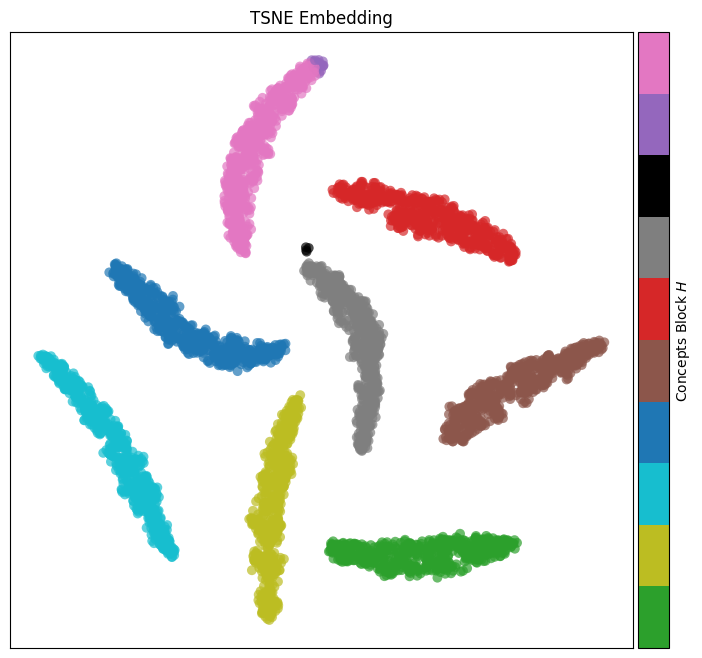

In [43]:
n_samples = len(labels)

color_palette = sns.color_palette('hls', num_clusters)
color_palette = sns.color_palette(['tab:green', 'tab:olive', 'tab:cyan', 'tab:blue', 'tab:brown', 'tab:red', 'tab:gray', 'black', 'tab:purple', 'tab:pink'], num_clusters)
cluster_colors = [color_palette[int(i)] for i in argmax_labels]

fig, axs = plt.subplots(1, 1, figsize=(8.5, 8))
# add random noise in case points are too close on top of another
axs.scatter(
    x[:, 0] + np.random.uniform(-1, 1, n_samples),
    x[:, 1] + np.random.uniform(-1, 1, n_samples),
    s=50, linewidth=0, c=cluster_colors, alpha=.7
)

axs.set_xticks([])
axs.set_yticks([])

axs.set_title(f"TSNE Embedding")

divider = make_axes_locatable(axs)
cax = divider.append_axes("right", size="5%", pad=0.05)
cmap = LinearSegmentedColormap.from_list('cat_colors', color_palette, N=len(color_palette))
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(-1, len(color_palette)), cmap=cmap),
                cax=cax, orientation='vertical', label='Concepts Block $H$')
cbar.set_ticks([])

plt.savefig('plots/similaritive_inpsection.pdf')

In [1]:
# reformulate merging dictionaries
pre_dict = {
    0: {},
    1: {},
    2: {},
    3: {},
    4: {0: [1, 2, 3], 5: [6]},
    5: {},
    6: {},
    7: {}, 
    8: {3: [4]},
    9: {},
    10: {},
    11: {},
    12: {14: [15], 17: [18, 19]},
    13: {},
    14: {},
    15: {1: [2]},
    }

result_dict = {}
ids =   [0, 1, 2,  3,   4, 5,  6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
num_c = [3, 8, 12, 264, 7, 15, 1, 2, 5, 1, 11, 1,  20, 5,  1,  3]
for b in range(16):
    result_dict[b] = {}
    for c_outer in range(num_c[b]):
        res_c = {}
        if c_outer in pre_dict[b].keys():
            for merge_idx in range(c_outer + 1, num_c[b]):
                if merge_idx in pre_dict[b][c_outer]:
                    res_c[merge_idx] = 1
                else:
                    res_c[merge_idx] = 0
        else:
            for merge_idx in range(c_outer + 1, num_c[b]):
                res_c[merge_idx] = 0
        result_dict[b][c_outer] = res_c
        
        # if c not in pre_dict[b].keys():
import pickle
pickle.dump(result_dict, open('plots/concepts_merge_dict.pkl', 'wb'))

In [2]:
delete_dict =     {0: [2],
     1: [4],
     2: [10, 11],
     3: list(range(264)),
     4: [],
     5: list(range(15)),
     6: list(range(1)),
     7: list(range(2)),
     8: [0],
     9: list(range(1)),
     10: list(range(11)),
     11: list(range(1)),
     12: [12],
     13: list(range(5)),
     14: list(range(1)),
     15: [],
     }

pickle.dump(delete_dict, open('plots/concepts_delete_dict.pkl', 'wb'))

In [3]:
result_dict

{0: {0: {1: 0, 2: 0}, 1: {2: 0}, 2: {}},
 1: {0: {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0},
  1: {2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0},
  2: {3: 0, 4: 0, 5: 0, 6: 0, 7: 0},
  3: {4: 0, 5: 0, 6: 0, 7: 0},
  4: {5: 0, 6: 0, 7: 0},
  5: {6: 0, 7: 0},
  6: {7: 0},
  7: {}},
 2: {0: {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0},
  1: {2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0},
  2: {3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0},
  3: {4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0},
  4: {5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0},
  5: {6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0},
  6: {7: 0, 8: 0, 9: 0, 10: 0, 11: 0},
  7: {8: 0, 9: 0, 10: 0, 11: 0},
  8: {9: 0, 10: 0, 11: 0},
  9: {10: 0, 11: 0},
  10: {11: 0},
  11: {}},
 3: {0: {1: 0,
   2: 0,
   3: 0,
   4: 0,
   5: 0,
   6: 0,
   7: 0,
   8: 0,
   9: 0,
   10: 0,
   11: 0,
   12: 0,
   13: 0,
   14: 0,
   15: 0,
   16: 0,
   17: 0,
   18: 0,
   19: 0,
   20: 0,
   21: 0,
   22: 0,
   